# 1. Visualizing raw data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd 
import numpy as np  
import seaborn as sns  
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.dates as md

import sys
import os
sys.path.append(os.path.abspath('../'))

import Airpeak

In [9]:
df = pd.read_csv('data/sample_classroom_CO2_data.csv')
df['Time'] = pd.to_datetime(df['Time'])
df

,Time,CO2_Concentration_ppm
0,2024-09-03 01:00:08,395
1,2024-09-03 01:01:21,389
2,2024-09-03 01:01:58,390
3,2024-09-03 01:02:44,393
4,2024-09-03 01:04:12,394
...,...,...
5994,2024-09-07 04:56:18,435
5995,2024-09-07 04:57:11,432
5996,2024-09-07 04:58:27,435
5997,2024-09-07 04:59:08,441


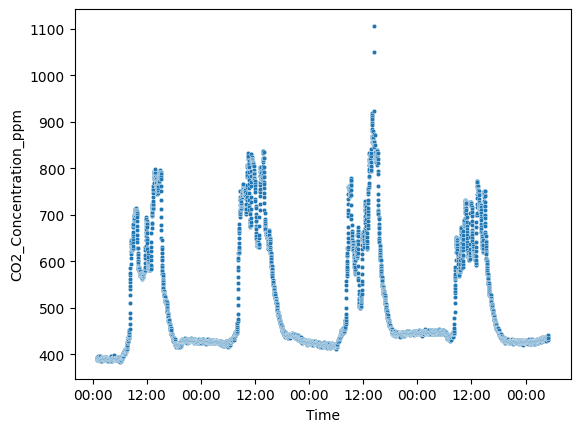

In [10]:
ax = sns.scatterplot(data=df,x='Time',y='CO2_Concentration_ppm',s=10)
myFmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

# 2. Preprocessing

## 2.1 outlier removal and smoothing

for noisy data such as PM reading from low-cost optical particle counters

In [11]:
df_or = Airpeak.outlier_removal(df,'CO2_Concentration_ppm',10)
df_or 

,Time,CO2_Concentration_ppm
0,2024-09-03 01:00:08,395
1,2024-09-03 01:01:21,389
2,2024-09-03 01:01:58,390
3,2024-09-03 01:02:44,393
4,2024-09-03 01:04:12,394
...,...,...
5994,2024-09-07 04:56:18,435
5995,2024-09-07 04:57:11,432
5996,2024-09-07 04:58:27,435
5997,2024-09-07 04:59:08,441


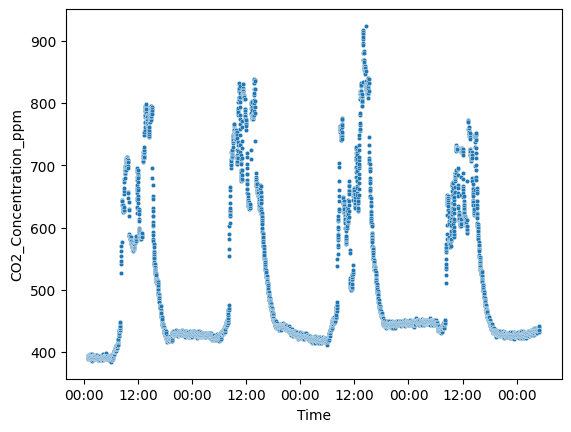

In [12]:
ax = sns.scatterplot(data=df_or,x='Time',y='CO2_Concentration_ppm',s=10)
myFmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
#note the two highest value of >1000 ppm is considered outlier and removed

In [13]:
df_sm = Airpeak.smoothing(df_or,'CO2_Concentration_ppm',5,2)
df_sm

,Time,CO2_Concentration_ppm
0,2024-09-03 01:00:08,394.085714
1,2024-09-03 01:01:21,390.857143
2,2024-09-03 01:01:58,389.914286
3,2024-09-03 01:02:44,392.485714
4,2024-09-03 01:04:12,394.428571
...,...,...
5994,2024-09-07 04:56:18,435.514286
5995,2024-09-07 04:57:11,432.600000
5996,2024-09-07 04:58:27,436.028571
5997,2024-09-07 04:59:08,436.714286


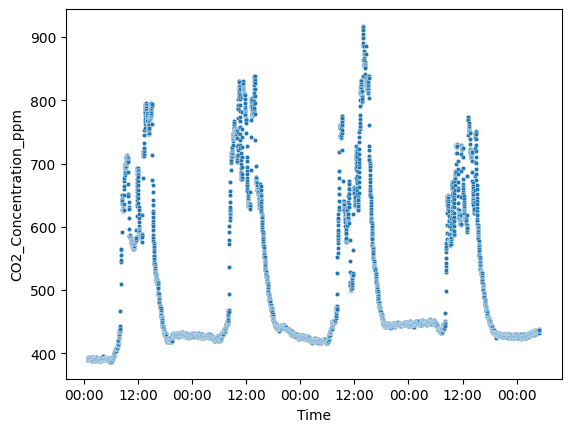

In [14]:
ax = sns.scatterplot(data=df_sm,x='Time',y='CO2_Concentration_ppm',s=10)
myFmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
#note the spikes are smoothed
#but we will continue with df_or

# 2.2 baseline recognition

not necessary if outdoor data available

In [15]:
df_bd = Airpeak.baseline_detection(df_sm,'CO2_Concentration_ppm',base_lambda = 1e7, base_p =0.0001)
#note that I have to adjust lambda and p
#try different values and see the results
df_bd

,Time,CO2_Concentration_ppm,baseline
0,2024-09-03 01:00:08,394.085714,379.750315
1,2024-09-03 01:01:21,390.857143,379.765028
2,2024-09-03 01:01:58,389.914286,379.779824
3,2024-09-03 01:02:44,392.485714,379.794702
4,2024-09-03 01:04:12,394.428571,379.809663
...,...,...,...
5994,2024-09-07 04:56:18,435.514286,424.334574
5995,2024-09-07 04:57:11,432.600000,424.341098
5996,2024-09-07 04:58:27,436.028571,424.347645
5997,2024-09-07 04:59:08,436.714286,424.354215


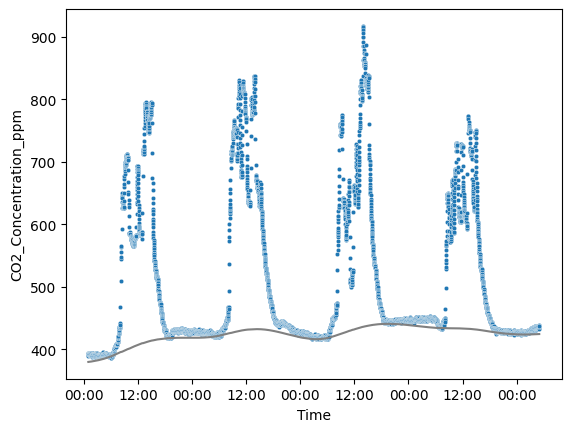

In [16]:
ax = sns.scatterplot(data=df_bd,x='Time',y='CO2_Concentration_ppm',s=10)
sns.lineplot(data=df_bd,x='Time',y='baseline',ax=ax,color='gray')
myFmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

# Generating data features for clustering

In [17]:
df_fg = Airpeak.feature_generation(df_bd,'CO2_Concentration_ppm','Time',diff_ma_window = 5, diff_rhl_window = 5)

# I am using droping NA as a lazy way to handle NAs generated by gradient calculation and log function
df_fg = df_fg.dropna(subset=['diff','diff_ma','diff_gd','diff_gd_ln','diff_gd_sign','diff_gd_abs','diff_rhl'])

df_fg

,Time,CO2_Concentration_ppm,baseline,min_diff,diff,diff_ma,diff_gd,diff_gd_ln,diff_gd_sign,diff_gd_abs,diff_rhl
1,2024-09-03 01:01:21,390.857143,379.765028,1.216667,11.092114,12.063247,0.171990,0.014383,1,0.171990,0.227962
2,2024-09-03 01:01:58,389.914286,379.779824,0.616667,10.134462,12.574379,0.828863,0.067294,1,0.828863,0.000000
3,2024-09-03 01:02:44,392.485714,379.794702,0.766667,12.691012,12.605215,0.040221,0.003195,1,0.040221,0.570093
4,2024-09-03 01:04:12,394.428571,379.809663,1.466667,14.618908,13.173111,0.387202,0.030046,1,0.387202,1.000000
5,2024-09-03 01:04:37,394.314286,379.824707,0.416667,14.489579,13.569495,0.951323,0.071152,1,0.951323,0.948320
...,...,...,...,...,...,...,...,...,...,...,...
5994,2024-09-07 04:56:18,435.514286,424.334574,1.116667,11.179712,11.636831,0.142580,0.012337,1,0.142580,0.497568
5995,2024-09-07 04:57:11,432.600000,424.341098,0.883333,8.258902,11.521736,-0.130296,-0.011253,0,0.130296,0.000000
5996,2024-09-07 04:58:27,436.028571,424.347645,1.266667,11.680927,11.218046,-0.239755,-0.021088,0,0.239755,0.786362
5997,2024-09-07 04:59:08,436.714286,424.354215,0.683333,12.360071,11.227630,0.014025,0.001250,1,0.014025,0.942425


# 3. Extracting decays

## 3.1 Recognize elevations

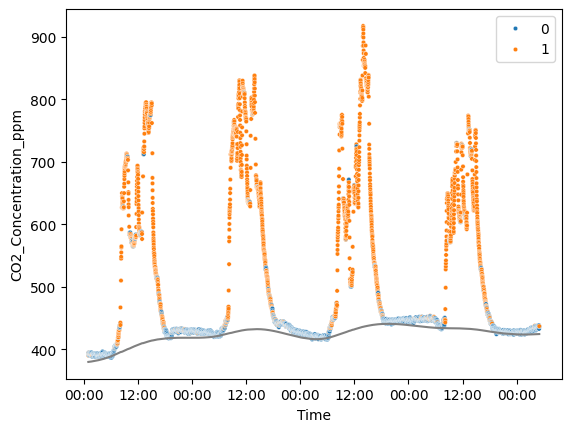

In [18]:
df_ele = Airpeak.k_means_ele(df_fg)

ax = sns.scatterplot(data=df_ele,x='Time',y='CO2_Concentration_ppm',hue='elevated',s=10)
sns.lineplot(data=df_bd,x='Time',y='baseline',ax=ax,color='gray')

myFmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

## 3.2 Differentiating build-ups and decays (or plateaus if reaches steady state)

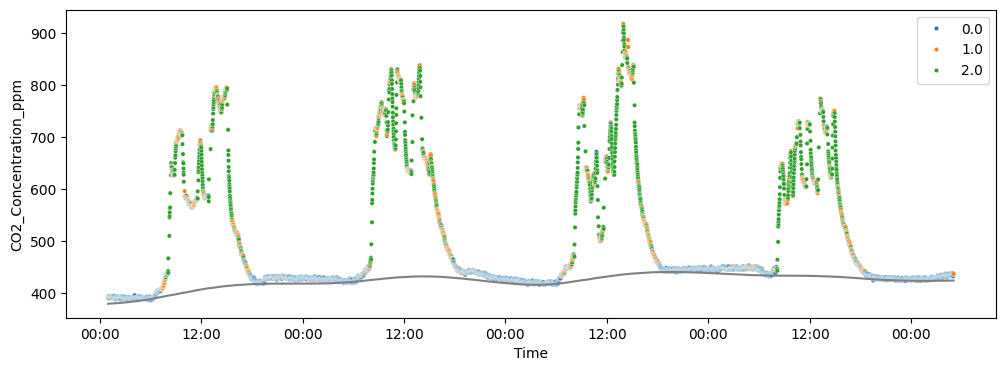

In [19]:
df_diff = Airpeak.k_means_diff(df_ele, 'Time')

plt.figure(figsize=(12,4))
palette = sns.color_palette("tab10")[0:3]
ax = sns.scatterplot(data=df_diff,x='Time',y='CO2_Concentration_ppm',hue='status_label',s=10,palette=palette)
sns.lineplot(data=df_bd,x='Time',y='baseline',ax=ax,color='gray')

myFmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

#separation looks reasonable to me @HERE

# 3.3 Extracting individual decay periods

In [21]:
df_decay = Airpeak.dbscan(df_diff, 'Time', eps=0.05, ms=5)
# please do play with eps and ms to understand their impact
# a larger eps tend to connect multiple decay periods as a larger one 
# a larger ms excludes very short decay periods 

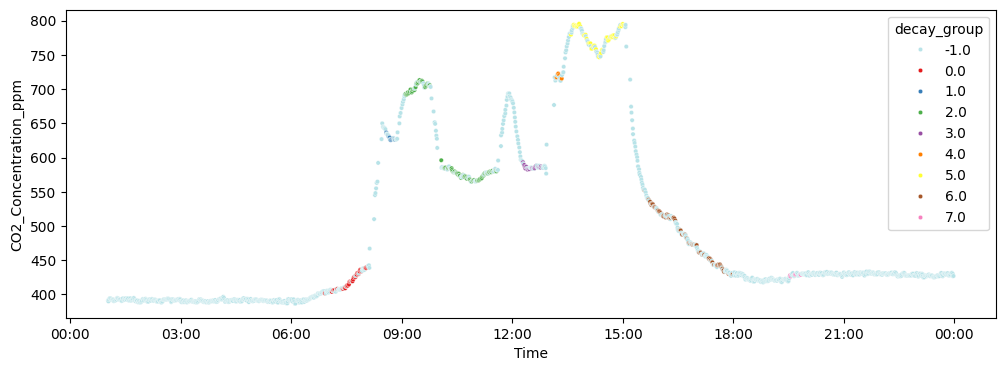

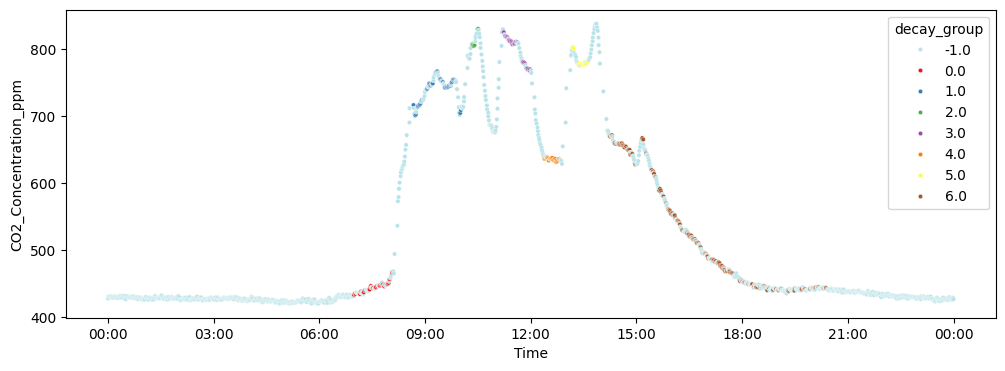

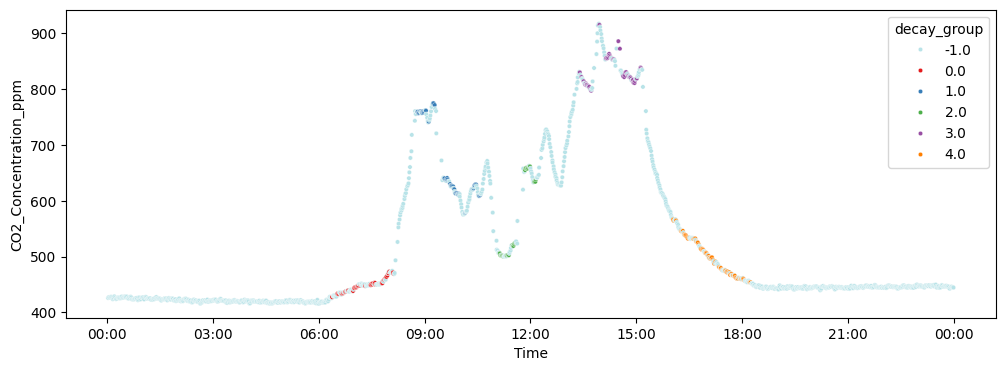

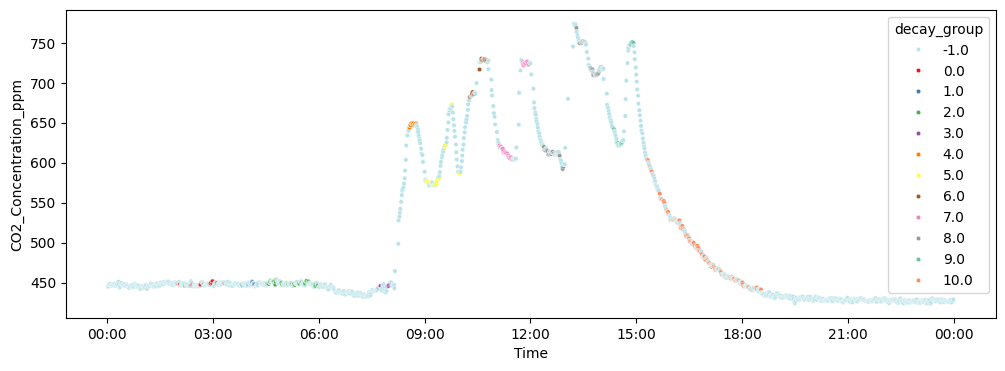

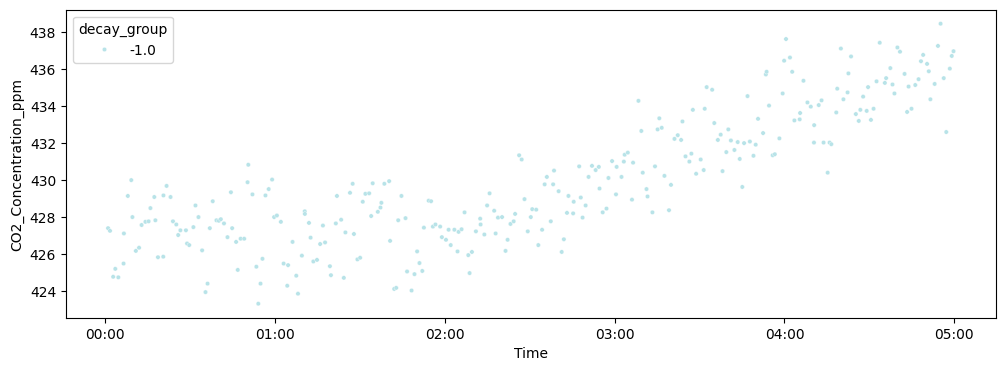

In [22]:
palette=[(0.72,0.89,0.91)]+list(sns.color_palette('Set1'))+list(sns.color_palette('Set2'))+list(sns.color_palette('Set1'))+list(sns.color_palette('Set2'))

date_list = df_decay['Date'].unique()
for date in date_list:
    plt.figure(figsize=(12,4))
    df_decay_singleday = df_decay.loc[df_decay['Date']==date]
    palette_num = len(df_decay_singleday['decay_group'].unique())
    ax = sns.scatterplot(data=df_decay_singleday,x='Time',y='CO2_Concentration_ppm',hue='decay_group',s=10,palette=palette[0:palette_num])
    myFmt = md.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(myFmt)

# 4. Mass balance

In [24]:
#I am running regression by date to have more flexibility
#when there's multiple locations,
#consider adding a loop for location and remember to add "location" to regression result

date_list = df_decay['Date'].unique()
decay_rate_result = pd.DataFrame()
for date in date_list:
    df_working = df_decay.loc[df_decay['Date']==date]
    decay_rate = Airpeak.decay_regress(df_working, 'CO2_Concentration_ppm','Time')
    decay_rate_result = pd.concat([decay_rate_result,decay_rate])
    
decay_rate_result

,pollutant,time,decay_start,decay_end,decay_rate,r2,ste,num_of_point,base_value,median_ele,max_diff,group,method
0,CO2_Concentration_ppm,2024-09-03 07:39:36,2024-09-03 06:54:38,2024-09-03 08:04:02,-1.473877,0.945819,0.102470,33,391.388395,25.470861,38.800000,0.0,decay
1,CO2_Concentration_ppm,2024-09-03 08:42:54,2024-09-03 08:34:29,2024-09-03 08:49:09,0.173795,0.709904,0.009096,9,396.348157,230.411783,-10.514286,1.0,decay
2,CO2_Concentration_ppm,2024-09-03 10:28:24,2024-09-03 09:06:12,2024-09-03 11:34:00,0.318142,0.822202,0.117398,81,398.040572,175.499274,-113.142857,2.0,decay
3,CO2_Concentration_ppm,2024-09-03 12:32:36,2024-09-03 12:17:15,2024-09-03 12:48:38,0.025716,0.089657,0.014317,19,407.858924,177.433521,-7.714286,3.0,decay
4,CO2_Concentration_ppm,2024-09-03 13:14:49,2024-09-03 13:11:59,2024-09-03 13:20:28,0.096978,0.235233,0.010579,5,409.861373,310.338649,-2.028571,4.0,decay
5,CO2_Concentration_ppm,2024-09-03 14:21:56,2024-09-03 13:35:27,2024-09-03 15:03:10,0.012255,0.018492,0.039907,52,410.780992,363.511870,13.142857,5.0,decay
6,CO2_Concentration_ppm,2024-09-03 16:44:24,2024-09-03 15:35:26,2024-09-03 17:58:59,0.918061,0.949007,0.152095,59,414.626000,71.106819,-122.800000,6.0,decay
7,CO2_Concentration_ppm,2024-09-03 19:40:43,2024-09-03 19:32:30,2024-09-03 19:49:51,-0.668528,0.375016,0.116982,5,418.106557,10.467381,0.800000,7.0,decay
0,CO2_Concentration_ppm,2024-09-04 07:36:32,2024-09-04 06:59:03,2024-09-04 08:04:50,-1.021862,0.890866,0.118414,30,423.304402,20.542647,34.142857,0.0,decay
1,CO2_Concentration_ppm,2024-09-04 09:27:11,2024-09-04 08:40:20,2024-09-04 10:01:08,-0.065258,0.213843,0.050007,43,426.141677,316.150878,-7.657143,1.0,decay


In [26]:
#Results contain short and less consistent decay periods

<Axes: xlabel='time', ylabel='decay_rate'>

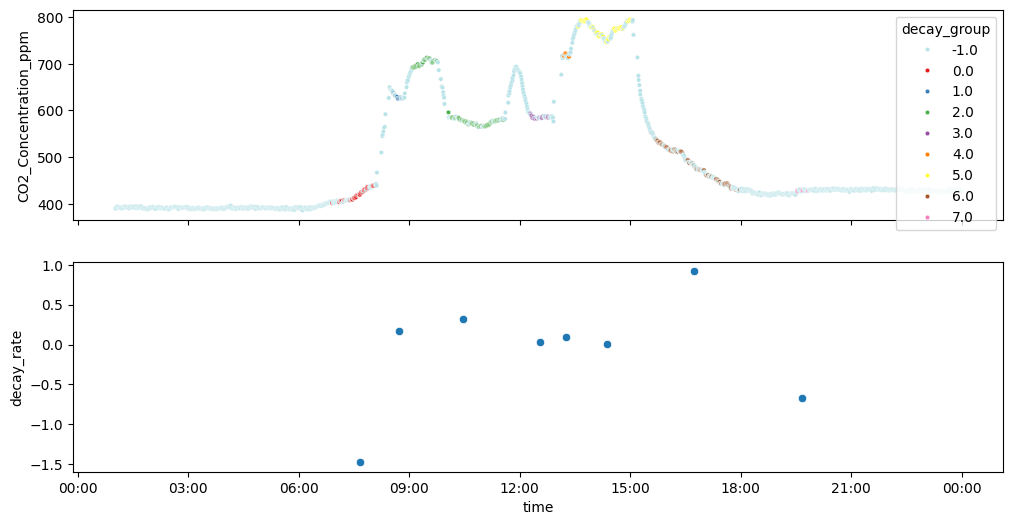

In [25]:
# An example for visualization
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (12,6),sharex=True)

palette=[(0.72,0.89,0.91)]+list(sns.color_palette('Set1'))+list(sns.color_palette('Set2'))+list(sns.color_palette('Set1'))+list(sns.color_palette('Set2'))

date = date_list[0]
df_decay_singleday = df_decay.loc[df_decay['Date']==date]

decay_rate_result['Date'] = decay_rate_result['time'].dt.date
df_result_singleday = decay_rate_result.loc[decay_rate_result['Date']==date]

palette_num = len(df_decay_singleday['decay_group'].unique())
sns.scatterplot(data=df_decay_singleday,x='Time',y='CO2_Concentration_ppm',hue='decay_group',s=10,ax=ax1,palette=palette[0:palette_num])
myFmt = md.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(myFmt)

sns.scatterplot(data=df_result_singleday, x='time',y='decay_rate',ax=ax2)

In [26]:
#We could run result filtration to select longer and more consistent ones for further analysis
decay_rate_result_selected = decay_rate_result.loc[(decay_rate_result['num_of_point']>=10)&(decay_rate_result['r2']>=0.9)]
decay_rate_result_selected

,pollutant,time,decay_start,decay_end,decay_rate,r2,ste,num_of_point,base_value,median_ele,max_diff,group,method,Date
0,CO2_Concentration_ppm,2024-09-03 07:39:36,2024-09-03 06:54:38,2024-09-03 08:04:02,-1.473877,0.945819,0.102470,33,391.388395,25.470861,38.800000,0.0,decay,2024-09-03
6,CO2_Concentration_ppm,2024-09-03 16:44:24,2024-09-03 15:35:26,2024-09-03 17:58:59,0.918061,0.949007,0.152095,59,414.626000,71.106819,-122.800000,6.0,decay,2024-09-03
3,CO2_Concentration_ppm,2024-09-04 11:31:16,2024-09-04 11:14:04,2024-09-04 11:58:53,0.221785,0.942410,0.012856,29,430.328012,378.833627,-55.342857,3.0,decay,2024-09-04
6,CO2_Concentration_ppm,2024-09-04 16:46:01,2024-09-04 14:15:05,2024-09-04 20:26:10,0.575870,0.935353,0.254231,152,432.213011,78.966778,-228.685714,6.0,decay,2024-09-04
0,CO2_Concentration_ppm,2024-09-05 07:28:07,2024-09-05 06:22:31,2024-09-05 08:07:04,-0.749345,0.908585,0.122420,40,418.632836,28.086601,41.485714,0.0,decay,2024-09-05
4,CO2_Concentration_ppm,2024-09-05 17:04:39,2024-09-05 16:02:44,2024-09-05 18:14:34,1.044731,0.973419,0.104585,65,438.956033,58.901820,-112.371429,4.0,decay,2024-09-05
6,CO2_Concentration_ppm,2024-09-06 10:36:38,2024-09-06 10:17:01,2024-09-06 10:45:42,-0.435601,0.926521,0.022317,18,433.554507,288.341224,45.057143,6.0,decay,2024-09-06
10,CO2_Concentration_ppm,2024-09-06 16:48:37,2024-09-06 15:19:18,2024-09-06 18:32:25,0.823241,0.989234,0.073553,81,431.349614,59.046122,-162.428571,10.0,decay,2024-09-06


<Axes: xlabel='time', ylabel='decay_rate'>

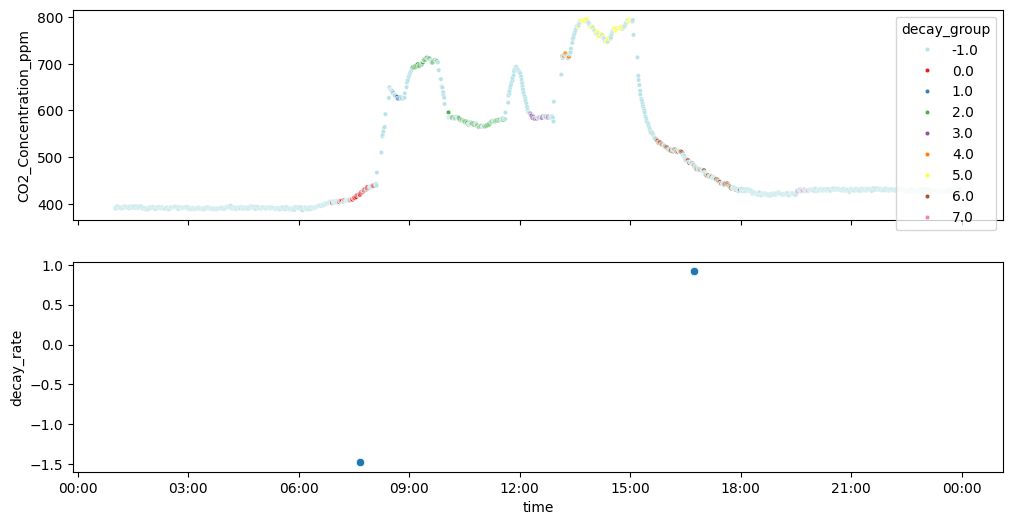

In [27]:
# An example for visualization
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (12,6),sharex=True)

palette=[(0.72,0.89,0.91)]+list(sns.color_palette('Set1'))+list(sns.color_palette('Set2'))+list(sns.color_palette('Set1'))+list(sns.color_palette('Set2'))

date = date_list[0]
df_decay_singleday = df_decay.loc[df_decay['Date']==date]

decay_rate_result_selected['Date'] = decay_rate_result_selected['time'].dt.date
df_result_selected_singleday = decay_rate_result_selected.loc[decay_rate_result_selected['Date']==date]

palette_num = len(df_decay_singleday['decay_group'].unique())
sns.scatterplot(data=df_decay_singleday,x='Time',y='CO2_Concentration_ppm',hue='decay_group',s=10,ax=ax1,palette=palette[0:palette_num])
myFmt = md.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(myFmt)

sns.scatterplot(data=df_result_selected_singleday, x='time',y='decay_rate',ax=ax2)